# Wprowadzenie do sieci neuronowych i uczenia maszynowego

## Lab: Własne moduły w PyTorch, regularyzacja i autoenkodery

---

**Autorzy materiałów:** Marek Wydmuch, Iwo Błądek, Jakub Bednarek<br>

---

## Uwaga

* **Aby wykonać polecenia należy najpierw przejść do trybu 'playground'. File -> Open in Playground Mode**
* Nowe funkcje Colab pozwalają na autouzupełnianie oraz czytanie dokumentacji.


## Cel ćwiczeń:

- zapoznanie się z tworzeniem własnych modułów w PyTorch
- wykorzystanie podstawowych mechanizmów regularyzacji: Dropout i Batch normalization

In [1]:
import numpy as np
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
CUDA available: True


In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.43MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Własne moduły (warstwy sieci neuronowych) w PyTorch



Na poprzednich zajęciach używaliśmy gotowych modułów reprezentujących warstwy sieci neuronowych by stworzyć główny moduł naszego modułu.

W PyTorch nie ma żadnej hierarchii modułów (jak np. w TensorFlow czy Keras, gdzie API jest podzielone na modele i warstwy). Każdy moduł może używać innych modułów jako swoich komponentów.

Poniżej przykładowa implementacja modułu warstwy liniowej całkowicie od podstaw.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class CustomLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomLayer, self).__init__()
        # Parametry (wagi) naszego modułu
        self.weights = nn.Parameter(torch.Tensor(input_dim, output_dim))
        # Inicjalizacja wag
        nn.init.xavier_normal_(self.weights)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return torch.mm(x, self.weights)

class CustomModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__()
        self.layers = nn.Sequential(
            CustomLayer(784, 512),
            nn.ReLU(),
            CustomLayer(512, 512),
            nn.ReLU(),
            CustomLayer(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)

In [4]:
# Setup naszego modelu
model = CustomModel(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

def accuracy(pred, target):
    return (pred.argmax(1) == target).type(torch.float).sum().item()

# Pętla treningowa i testowa
def train_and_test(
        train_loader,
        test_loader,
        model,
        optimizer,
        criterion,
        metric=None,
        epochs=10,
        verbose=False
    ):
    epochs_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_metric = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.cuda()
            target = target.cuda()
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            if verbose and batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
            train_loss += loss.item() * data.size(0)
            train_metric += metric(pred, target)
        if verbose:
            train_loss /= len(train_loader.dataset)
            train_metric /= len(train_loader.dataset)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Train {metric.__name__}: {train_metric:.4f}")

        model.eval()
        test_metric = 0
        test_loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.cuda()
            target = target.cuda()
            pred = model(data)
            loss = criterion(pred, target)
            test_loss += loss.item() * data.size(0)
            test_metric += metric(pred, target)
        if verbose:
            test_loss /= len(test_loader.dataset)
            test_metric /= len(test_loader.dataset)
            print(f"Test loss: {test_loss:.4f}")
            print(f"Test accuracy: {test_metric:.4f}")
            print("-------------------------------")

        epochs_history.append({
          "epoch": epoch,
          "train_loss": train_loss,
          f"train_{metric.__name__}": train_metric,
          "test_loss": test_loss,
          f"test_{metric.__name__}": test_metric
        })
    return epochs_history

_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)

Epoch: 0, Batch: 0, Loss: 2.3048
Epoch: 0, Batch: 100, Loss: 1.5590
Epoch: 0, Batch: 200, Loss: 1.5263
Epoch: 0, Batch: 300, Loss: 1.5279
Epoch: 0, Batch: 400, Loss: 1.4839
Train loss: 1.5639
Train accuracy: 0.9049
Test loss: 1.5136
Test accuracy: 0.9504
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.4897
Epoch: 1, Batch: 100, Loss: 1.4842
Epoch: 1, Batch: 200, Loss: 1.4911
Epoch: 1, Batch: 300, Loss: 1.5100
Epoch: 1, Batch: 400, Loss: 1.4887
Train loss: 1.5026
Train accuracy: 0.9603
Test loss: 1.5038
Test accuracy: 0.9586
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.5171
Epoch: 2, Batch: 100, Loss: 1.4756
Epoch: 2, Batch: 200, Loss: 1.4781
Epoch: 2, Batch: 300, Loss: 1.4870
Epoch: 2, Batch: 400, Loss: 1.4873
Train loss: 1.4930
Train accuracy: 0.9693
Test loss: 1.4935
Test accuracy: 0.9682
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4966
Epoch: 3, Batch: 100, Loss: 1.4925
Epoch: 3, Batch: 200, Loss: 1.4789
Epoch: 3, Batch: 300, Loss: 1.4890
E

### Zadanie 1

Stwórz prosty model
- warstwy konwolucyjnej (Conv2D): 32 filtry 3x3,
- konwolucyjnej: 64 filtry 3x3,
- warstwy MaxPooling (MaxPooling2D): 2x2
- warstwy ukrytej gęstej (Dense): 128 neuronów,
- warstwy wyjściowej.

Ważne:
- w każdej warstwie poza warstwą wyjściową funkcją aktywacji powinno być relu,
- funkcja aktywacji dla warstwy wyjściowej to softmax,
- między częścią konwolucyjną a gęstą trzeba spłaszczyć tensor przy pomocy warstwy `nn.Flatten`.

In [5]:
class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super(CustomConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class CustomDense(nn.Module):
    def __init__(self, in_features, out_features):
        super(CustomDense, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

class SimpleModel(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleModel, self).__init__()
        self.layers = nn.Sequential(
            CustomConv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            CustomConv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            CustomDense(in_features=64 * 14 * 14, out_features=128),
            nn.Linear(in_features=128, out_features=num_classes),
            nn.Softmax(dim=1)
        )
        self._initialize_weights()

    # Inicjalizacja parametrów, która znacząco poprawi początkowe uczenie
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

model = SimpleModel(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters())
_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)

Epoch: 0, Batch: 0, Loss: 2.3014
Epoch: 0, Batch: 100, Loss: 1.5901
Epoch: 0, Batch: 200, Loss: 1.6230
Epoch: 0, Batch: 300, Loss: 1.4886
Epoch: 0, Batch: 400, Loss: 1.4784
Train loss: 1.5698
Train accuracy: 0.8948
Test loss: 1.4871
Test accuracy: 0.9747
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.4725
Epoch: 1, Batch: 100, Loss: 1.4886
Epoch: 1, Batch: 200, Loss: 1.4817
Epoch: 1, Batch: 300, Loss: 1.4740
Epoch: 1, Batch: 400, Loss: 1.4817
Train loss: 1.4830
Train accuracy: 0.9792
Test loss: 1.4781
Test accuracy: 0.9839
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.4837
Epoch: 2, Batch: 100, Loss: 1.4847
Epoch: 2, Batch: 200, Loss: 1.4821
Epoch: 2, Batch: 300, Loss: 1.4938
Epoch: 2, Batch: 400, Loss: 1.4676
Train loss: 1.4768
Train accuracy: 0.9850
Test loss: 1.4770
Test accuracy: 0.9849
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4697
Epoch: 3, Batch: 100, Loss: 1.4855
Epoch: 3, Batch: 200, Loss: 1.4615
Epoch: 3, Batch: 300, Loss: 1.4896
E

## Zadanie 2

Na podstawie powyższego przykładu stwórz moduł bloku ResNet.
Zadbaj o to by rozmiary tensorów po warstwach konwolucyjnych się nie zmieniały.

![resnet](https://miro.medium.com/max/1000/1*6HDuqhUzP92iXhHoS0Wl3w.png)

Zmodyfikuj model z zadania 1, zamieniając warstwy konwolucyjne na dwa modele bloku ResNet.



In [6]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ResNetBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.layers(x)
        out = self.relu(out + identity) # tu pojawia się problem wymiarowości out i identity
        return out

class CustomDense(nn.Module):
    def __init__(self, in_features, out_features):
        super(CustomDense, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

class SimpleModel(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleModel, self).__init__()
        self.layers = nn.Sequential(
            ResNetBlock(in_channels=1, out_channels=32),
            ResNetBlock(in_channels=32, out_channels=64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            CustomDense(in_features=64 * 14 * 14, out_features=128),
            nn.Linear(in_features=128, out_features=num_classes),
            nn.Softmax(dim=1)
        )
        self._initialize_weights()

    # Inicjalizacja parametrów, która znacząco poprawi początkowe uczenie
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

model = SimpleModel(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters())
_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)

RuntimeError: The size of tensor a (64) must match the size of tensor b (32) at non-singleton dimension 1

## Regularyzacja

### Zadanie 3

Rozszerz model stworzony w zadaniu 1 o dwie warstwy Dropout (nn.Dropout):
- jedna po warstwie MaxPooling (wartość współczynnika odrzucenia 0.25)
- druga po gęstej warstwie ukrytej (Dense), wartość współczynnika odrzucenia 0.5.
- dodaj opcję włączenia i wyłączenia dropoutu jako argument konstruktora modułu modelu.



In [7]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes=10, dropout_after_pooling=True, dropout_after_dense=True):
        super(SimpleModel, self).__init__()

        layers = [
            CustomConv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            CustomConv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ]

        if dropout_after_pooling:
            layers.append(nn.Dropout(p=0.25))

        layers.append(nn.Flatten())
        layers.append(CustomDense(in_features=64 * 14 * 14, out_features=128))

        if dropout_after_dense:
            layers.append(nn.Dropout(p=0.5))

        layers.append(nn.Linear(in_features=128, out_features=num_classes))
        layers.append(nn.Softmax(dim=1))

        self.layers = nn.Sequential(*layers)

        self._initialize_weights()

    # Inicjalizacja parametrów, która znacząco poprawi początkowe uczenie
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

model = SimpleModel(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters())
_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)


Epoch: 0, Batch: 0, Loss: 2.3019
Epoch: 0, Batch: 100, Loss: 1.6076
Epoch: 0, Batch: 200, Loss: 1.5524
Epoch: 0, Batch: 300, Loss: 1.5139
Epoch: 0, Batch: 400, Loss: 1.5154
Train loss: 1.5690
Train accuracy: 0.8981
Test loss: 1.4910
Test accuracy: 0.9707
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.5167
Epoch: 1, Batch: 100, Loss: 1.5205
Epoch: 1, Batch: 200, Loss: 1.4919
Epoch: 1, Batch: 300, Loss: 1.5103
Epoch: 1, Batch: 400, Loss: 1.4870
Train loss: 1.5014
Train accuracy: 0.9611
Test loss: 1.4831
Test accuracy: 0.9786
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.5104
Epoch: 2, Batch: 100, Loss: 1.4705
Epoch: 2, Batch: 200, Loss: 1.5003
Epoch: 2, Batch: 300, Loss: 1.5133
Epoch: 2, Batch: 400, Loss: 1.4849
Train loss: 1.4922
Train accuracy: 0.9698
Test loss: 1.4803
Test accuracy: 0.9810
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.5000
Epoch: 3, Batch: 100, Loss: 1.5268
Epoch: 3, Batch: 200, Loss: 1.4927
Epoch: 3, Batch: 300, Loss: 1.4921
E

### Zadanie 4
Rozszerz model stworzony w poprzednich zadaniach o dwie warstwy Batch normalization (nn.BatchNorm2d) po warstwach konwolucyjnych. Dodaj opcję włączenia i wyłączenia dropoutu jako argument konstruktora modułu modelu.



In [8]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes=10, dropout_after_pooling=True, dropout_after_dense=True, use_batchnorm=True):
        super(SimpleModel, self).__init__()

        layers = [
            CustomConv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        ]

        if use_batchnorm:
            layers.append(nn.BatchNorm2d(32))

        layers.append(CustomConv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))

        if use_batchnorm:
            layers.append(nn.BatchNorm2d(64))

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        if dropout_after_pooling:
            layers.append(nn.Dropout(p=0.25))

        layers.append(nn.Flatten())
        layers.append(CustomDense(in_features=64 * 14 * 14, out_features=128))

        if dropout_after_dense:
            layers.append(nn.Dropout(p=0.5))

        layers.append(nn.Linear(in_features=128, out_features=num_classes))
        layers.append(nn.Softmax(dim=1))

        self.layers = nn.Sequential(*layers)

        self._initialize_weights()

    # Inicjalizacja parametrów, która znacząco poprawi początkowe uczenie
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

model = SimpleModel(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters())
_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)


Epoch: 0, Batch: 0, Loss: 2.3153
Epoch: 0, Batch: 100, Loss: 1.6032
Epoch: 0, Batch: 200, Loss: 1.6150
Epoch: 0, Batch: 300, Loss: 1.5357
Epoch: 0, Batch: 400, Loss: 1.5443
Train loss: 1.5934
Train accuracy: 0.8673
Test loss: 1.4947
Test accuracy: 0.9670
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.5246
Epoch: 1, Batch: 100, Loss: 1.4849
Epoch: 1, Batch: 200, Loss: 1.5260
Epoch: 1, Batch: 300, Loss: 1.5195
Epoch: 1, Batch: 400, Loss: 1.5085
Train loss: 1.5125
Train accuracy: 0.9486
Test loss: 1.4865
Test accuracy: 0.9749
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.5184
Epoch: 2, Batch: 100, Loss: 1.4874
Epoch: 2, Batch: 200, Loss: 1.4693
Epoch: 2, Batch: 300, Loss: 1.5073
Epoch: 2, Batch: 400, Loss: 1.4922
Train loss: 1.5017
Train accuracy: 0.9590
Test loss: 1.4872
Test accuracy: 0.9736
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4894
Epoch: 3, Batch: 100, Loss: 1.4799
Epoch: 3, Batch: 200, Loss: 1.5241
Epoch: 3, Batch: 300, Loss: 1.4614
E

### Zadanie 5
Porównaj model bez oraz z różnych kombinacjami technik regularyzacji (z dropoutem ale bez batch norm., bez dropout ale z batch norm., z dropoutem i z batch norm.).
Stwórz cztery wykresy:
- błąd funkcji celu dla zbioru treningowego,
- błąd funkcji celu dla zbioru walidacyjnego,
- trafność klasyfikacji dla zbioru treningowego,
- trafność klasyfikacji dla zbioru walidacyjnego.

Trening modelu: Model bez regularyzacji
Trening modelu: Model z Dropoutem (bez BatchNorm)
Trening modelu: Model z BatchNorm (bez Dropoutu)
Trening modelu: Model z Dropoutem i BatchNorm


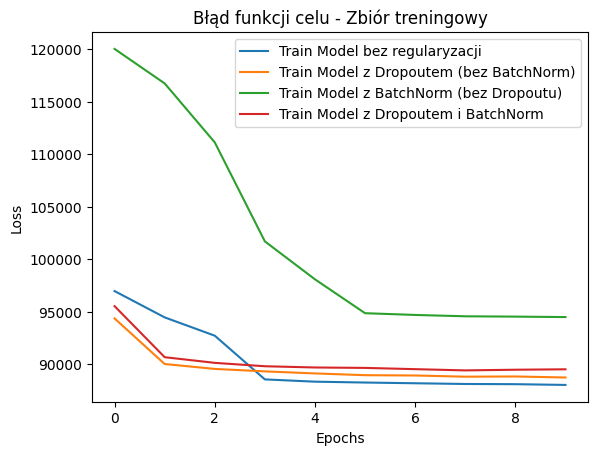

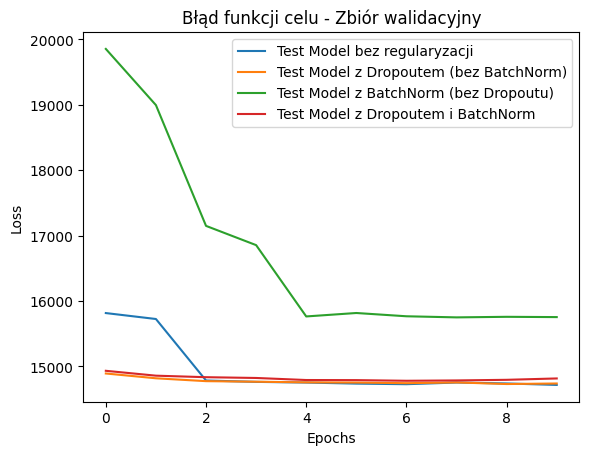

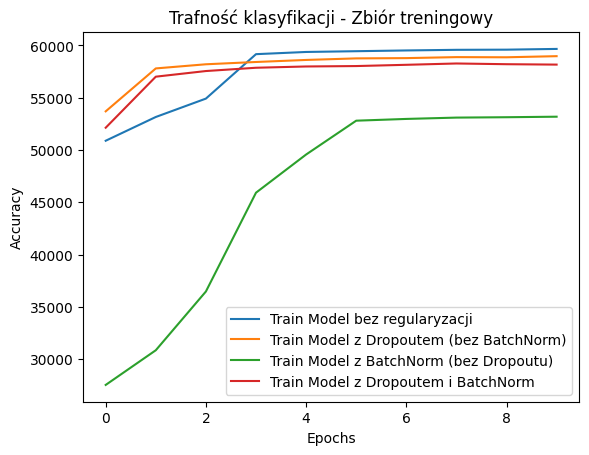

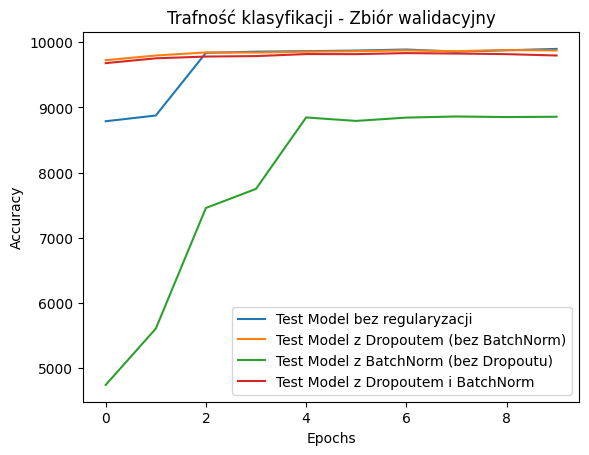

In [10]:
import matplotlib.pyplot as plt

def plot_loss_split(history_list, label_list):
    epochs = [entry['epoch'] for entry in history_list[0]]

    plt.figure()
    for history, label in zip(history_list, label_list):
        train_loss = [entry['train_loss'] for entry in history]
        plt.plot(epochs, train_loss, label=f"Train {label}")
    plt.title("Błąd funkcji celu - Zbiór treningowy")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    for history, label in zip(history_list, label_list):
        test_loss = [entry['test_loss'] for entry in history]
        plt.plot(epochs, test_loss, label=f"Test {label}")
    plt.title("Błąd funkcji celu - Zbiór testowy")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_accuracy_split(history_list, label_list):
    epochs = [entry['epoch'] for entry in history_list[0]]

    plt.figure()
    for history, label in zip(history_list, label_list):
        train_accuracy = [entry['train_accuracy'] for entry in history]
        plt.plot(epochs, train_accuracy, label=f"Train {label}")
    plt.title("Trafność klasyfikacji - Zbiór treningowy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure()
    for history, label in zip(history_list, label_list):
        test_accuracy = [entry['test_accuracy'] for entry in history]
        plt.plot(epochs, test_accuracy, label=f"Test {label}")
    plt.title("Trafność klasyfikacji - Zbiór testowy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

models = [
    SimpleModel(num_classes=10, dropout_after_dense=False, dropout_after_pooling=False, use_batchnorm=False).cuda(),
    SimpleModel(num_classes=10, use_batchnorm=False).cuda(),
    SimpleModel(num_classes=10, dropout_after_dense=False, dropout_after_pooling=False).cuda(),
    SimpleModel(num_classes=10).cuda()
]

label_list = [
    "Model bez 'dodatków'",
    "Model z Dropoutem (bez BatchNorm)",
    "Model z BatchNorm (bez Dropoutu)",
    "Model z Dropoutem i BatchNorm"
]

history_list = []
for model, name in zip(models, label_list):
    print(f"Trening modelu: {name}")
    optimizer = optim.Adam(model.parameters())
    history = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10)
    history_list.append(history)

# Rysowanie wykresów
plot_loss_split(history_list, label_list)
plot_accuracy_split(history_list, label_list)


## Autoenkodery

Ideę autoenkodera prezentuje poniższy rysunek:
![label-autoencoder_schema](https://drive.google.com/uc?export=view&id=1Ai2ER1ppKfnHg5t_lCwO_fvvFNe59dgd)

Widzimy tutaj, że obrazek ze zbioru MNIST o rozmiarze 28 x 28 został skompresowany przez **enkoder** do tensora o rozmiarze 5 x 2. Tensor ten nosi nazwę **wektora zmiennych ukrytych** (ang. latent vector). Następnie **dekoder** przyjął ten wektor na wejście, i odtworzył oryginalny obrazek. Jest to przykład zadania **autoasocjacji**, gdzie celem uczenia sieci neuronowej jest możliwie wierne odtworzenie danych wejściowych. Zadanie to może się wydawać bez sensu w odosobnieniu (po co odtwarzać coś, co już mamy?), jednak to co nas najbardziej interesuje w autoenkoderze to wektor zmiennych ukrytych. Jako że skompresowaliśmy cały obrazek do 10 wartości, to by realistyczne odtworzenie z nich oryginalnego obrazka było możliwe, każda z tych wartości musi 1) zawierać o nim możliwie dużo informacji, 2) nieistotne detale oryginalnego obrazka muszą zostać pominięte. Wyciągnęliśmy więc z danych informacyjną "esencję", pozbyliśmy się redundatnych elementów opisu.

<br>

Najważniejszą cechą autoenkodera jest właśnie **uczenie się efektywnego kodowania danych**, co zazwyczaj wiąże się z redukcją wymiarowości (tzw. 'undercomplete autoencoders'), choć można też uczyć autoenkodery o kodowaniu zwiększającym wymiarowość (tzw. 'overcomplete autoencoders'). Skupimy się na autoenkoderach zmniejszających wymiarowość, bo ich uczenie jest znacznie prostsze. W przeciwieństwie do np. PCA kodowanie uzyskane przez taki autoenkoder może być nieliniowe, tak więc zmienne ukryte mają więcej elastyczności w reprezentacji danych. Selekcja atrybutów, której podstawy omawialiśmy wcześniej na przedmiocie, również redukuje wymiarowość, ale nie zmienia informacji w atrybutach. W ogólności techniki redukcji wymiarowości tworzą zupełnie nowe atrybuty ze starych (np. $Y_1 = 0.5X_1 - 0.25X_2^2 + \log_2 X_3$, gdzie $Y_1$ to nowy atrybut, a $X_i$ to oryginalne atrybuty). Wiele zastosowań autoenkoderów buduje właśnie na tej zdolności, a także na tym, że dzięki procesowi uczenia sieci tworzymy metodę redukcji wymiarowości zoptymalizowaną do konkretnego problemu.

<br>

Autoenkodery mają wiele potencjalnych zastosowań, przykładowo:
* Redukcja wymiarowości - uczymy autoenkoder w trybie autoasocjacji, i naszym celem jest zmniejszenie wymiarowości danych, czyli zastąpienie oryginalnego obiektu jego wektorem zmiennych ukrytych. Można użyć jako alternatywy dla selekcji atrybutów i dedykowanych metod redukcji wymiarowości (PCA, LDA, etc.).
* Grupowanie - uczymy autoenkoder w trybie autoasocjacji, wykorzystujemy wektory zmiennych ukrytych uzyskane dla danych uczących jako wejście do algorytmu grupowania (np. k-means).
* Wyszukiwanie informacji - uczymy autoenkoder w trybie autoasocjacji, wykorzystujemy wektor zmiennych ukrytych jako hasz obiektu. Jeżeli chcemy znaleźć w bazie danych obiekty podobne do zadanego obiektu $X$, to generujemy wektor zmiennych ukrytych (hasz) $X$ przy użyciu enkodera i szukamy obiektów w zbiorze o najbardziej zbliżonych haszach. Technika ta nazywana jest haszowaniem semantycznym.
* Wykrywanie anomalii - uczymy autoenkoder w trybie autoasocjacji wyłącznie na przypadkach "normalnych". Liczymy na to, że jak kiedykolwiek autoenkoder dostanie do przetworzenia przypadek odstający/anomalię, to nie da rady jej dobrze zrekonstruować i błąd będzie wysoki (właśnie przez to, że nie miał szansy się na nich nauczyć).
* Generowanie danych - uczymy autoenkoder w trybie autoasocjacji, a następnie jak chcemy uzyskać różne warianty danego obrazu/obiektu, to modyfikujemy jego wygenerowany przez enkoder wektor zmiennych ukrytych, i dajemy go do przetworzenia dekoderowi. Możemy też po prostu losowo próbkować przestrzeń wektorów ukrytych i obserwować wyniki po przetworzeniu przez dekoder. Przy odrobinie szczęścia jakaś zmienna ukryta może np. odpowiadać za wyraz twarzy człowieka, i zmieniając wartości tej zmiennej możemy zmieniać wyłącznie wyraz twarzy człowieka na zdjęciu. Do tego zadania zazwyczaj wykorzystywany jest zmodyfikowany wariant autoenkodera: autoenkoder wariacyjny.
* Odszumianie - uczymy autoenkoder w trybie heteroasocjacji: *zaszumiony obraz* -> *oryginalny obraz*. Liczymy na to, że enkoder i dekoder nauczą się poprawnie rozpoznawać szum jako element redundantny, nieniosący żadnej informacji.<br>
![label-autoencoder_denoising](https://drive.google.com/uc?export=view&id=1a1fP7CWjzKSwo0txUBUMwaxTrpt6LzyH)



### Zadanie 6

Zaimplementuj autoenkoder o następującej architekturze:
* Enkoder: Dense(100) -> Dense(50) -> Dense(10) (wektor zmiennych ukrytych).
* Dekoder: Dense (50) -> Dense(100) -> Dense(784) (wyjściowy zrekonstruowany obrazek)

Funkcję aktywacji ustaw jako 'relu'. Jako miara błędu użyte zostanie MSE.

In [17]:
import torch
import torch.nn as nn
import torch.nn.init as init

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"""
# to dodałem, bo są błędy:
RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)
"""

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 100), # Colab tutaj sam już autouzupełnia wszystkie warstwy, więc pewnie bardzo dobrze zna ten notatnik ;)
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 784),
            nn.Sigmoid() #o, a to colab sam z siebie dodał, ciekawe czy powinno tu być!
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                init.constant_(m.bias, 0)

    def forward(self, x):
        # Ensure input is flattened
        x = x.view(-1, 784)
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded

# Model creation
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 20
_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

### Zadanie 7

Użyj zaimplementowanego wyżej autoenkodera by zaobserwować jak zmienia się odtwarzany obraz gdy zmienia się tylko jeden element wektora zmiennych ukrytych. Zadanie wykonywane jest w następujących krokach:
1. Użyj nauczonego enkodera z poprzedniego zadania na przypadku uczącym wybranej cyfry (dowolnej) by uzyskać wektor zmiennych ukrytych.
2. Wybierz konkretną zmienną ukrytą w tym wektorze, np. tę o indeksie 0.
3. W pętli podstawiaj różne wartości do tej zmiennej wektora z pewnym krokiem, i obserwuj obrazki generowane przez dekoder.

In [ ]:
example = train_data[0][0]
print("Original image")
plt.imshow(example.reshape((28, 28)), cmap='gray')
plt.show()

x = np.expand_dims(example, 0) # Dodatkowy wymiar na pozycję przypadku w 'batchu', by wymiarowość się zgadzała

# Po uczeniu wykonanym w poprzednim zadaniu, mamy dostęp do już nauczonych składowych sieci
latent_vector = # Użyj enkodera
output = # Użyj dekodera

print("Reconstructed image")
plt.imshow(output.reshape(output, (28, 28)), cmap='gray')
plt.show()

print(f"latent_vector: {latent_vector}")

for e in np.linspace(np.min(latent_vector), np.max(latent_vector), 11):
  print(f"e: {e}")

  # Zmień wektor zmiennych ukrytych, ustawiając wartość e w odpowiednim polu wektora
  ...
  # Użyj dekodera by wygenerować obrazek z nowego wektora zmiennych ukrytych
  ...
  # Pokaż wynikowy obrazek
  ...

### Zadanie 8

Wykorzystaj kod z poprzednich zadań by nauczyć autoenkoder odszumiania. Parę uwag:
* Musisz zmodyfikować zbiór uczący poprzez dodanie sztucznego szumu. Można to zrobić albo poprzez zmianę wartości kilku losowych pikseli w każdym obrazku, albo dodanie macierzy z małymi losowo generowanymi liczbami do obrazka (do każdego obrazka innej!). Oczekiwaną odpowiedzą podczas uczenia będzie oryginalny obrazek bez szumu.
* Architektura enkodera i dekodera może pozostać bez zmian, ale będziesz musiał ją nauczyć na nowym zbiorze danych, tak więc by nie psuć wyników z zadania nr 6 sugeruję przeklejenie odpowiedniego kodu tutaj.
* Zademonstruj działanie odszumiania poprzez pokazanie przypadku z szumem, a następnie zrekonstruowanego obrazka bez szumu po przetworzeniu przez autoenkoder.

In [ ]:
...